In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from google.colab import drive
import json
import os
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import pickle
#configure LaTeX parameters to generate figures
lab_size = 15
plt.rcParams.update({
    'font.size': lab_size,
    'font.family': 'Times New Roman',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}'  # Load amsmath package
})

In [ ]:
# natural time to timestep converter
def time_ts(natural_time):
  return int(natural_time/0.01)

In [ ]:
# RK4 integrator (SINGLE STEP)
def RK4step(func, current_state, t, dt):
    k1 = func(t, current_state)
    k2 = func(t + 0.5 * dt, current_state + 0.5 * dt * k1)
    k3 = func(t + 0.5 * dt, current_state + 0.5 * dt * k2)
    k4 = func(t + dt, current_state + dt * k3)
    return current_state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Lorenz system - Drive

\begin{align*}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{align*}

In [ ]:
 class LorenzSystem:

    def __init__(self):
        self.sigma = 10.0
        self.rho = 28.0
        self.beta = 8.0 / 3.0
        self.state = np.array([1, 1, 1])

    def __call__(self, t, u):
        return np.array([
            self.sigma * (u[1] - u[0]),
            u[0] * (self.rho - u[2]) - u[1],
            u[0] * u[1] - self.beta * u[2]
        ])

    def reinitialise_ic(self):
        self.state = np.array([1, 1, 1])

    def randomise_ic(self):
        self.state = 2 * (np.random.rand(self.state.size) - 0.5)

In [ ]:
lorenz_system = LorenzSystem()
lorenz_system.randomise_ic()
dt = 0.01
t_end = 300
num_timesteps = int(t_end / dt)

states = [lorenz_system.state]
t = 0.0
for _ in range(num_timesteps):
    lorenz_system.state = RK4step(lorenz_system, lorenz_system.state, t, dt)
    states.append(lorenz_system.state)
    t += dt

states = np.array(states)

<ipython-input-129-933ec1db8f45>:3: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


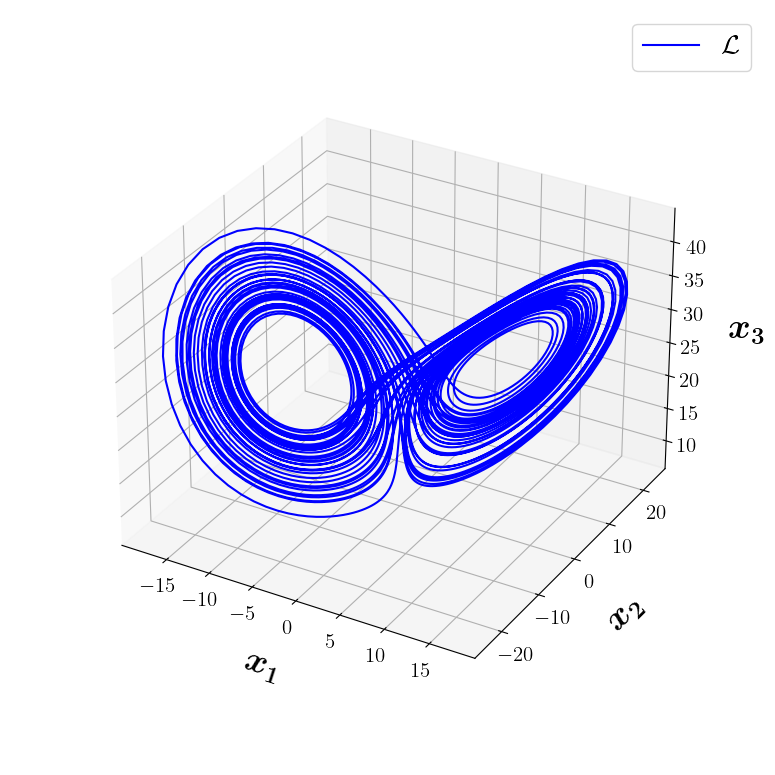

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.dist = 12
ax.zaxis.set_rotate_label(False)  # disable automatic rotation

# Plot RK4 continuation
ax.plot(states[time_ts(250):, 0], states[time_ts(250):, 1], states[time_ts(250):, 2], color='blue', label = "$\mathcal{L}$")

ax.set_xlabel(r'$\boldsymbol{x_1}$', size=25, labelpad= 20)
ax.set_ylabel(r'$\boldsymbol{x_2}$', size=25, labelpad= 20)
ax.set_zlabel(r'$\boldsymbol{x_3}$', size=25, labelpad = 20, rotation = 0)
ax.legend(fontsize=20, labelspacing=1.0, loc='best')
plt.tight_layout()

# Show the plot
plt.savefig(f'drive/My Drive/thesis_figures/chapter_3/Lorenz_attractor.pdf',transparent = True, bbox_inches = 'tight')

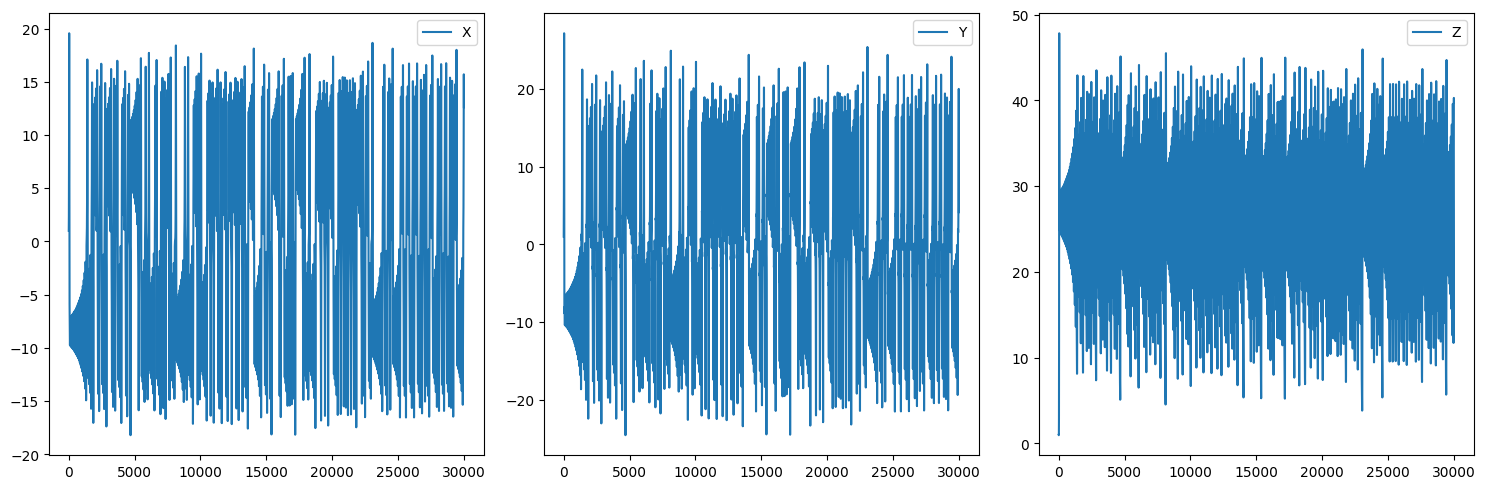

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

labels = ['X', 'Y', 'Z']
for i, label in enumerate(labels):
    axs[i].plot(states[:, i], label=label)
    axs[i].legend()

plt.tight_layout()
plt.show()

# Reservoir System - Response
\begin{align*}
\frac{d \mathbf{r}(t)}{dt} = \gamma \left[ -r(t) + \tanh \left( M r(t) + \sigma W_{\text{in}} u(t) \right) \right]
\end{align*}

# train - done
# randomise r
# simulate for 100 seconds the predictions from there

In [ ]:
class ReservoirComputer:

    def __init__(self, drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma):

        np.random.seed(1911) # seed for deterministic initialisation.

        # Randomly initialise reservoir state and drive system.
        self.r = 2 * (np.random.rand(reservoir_size) - 0.5)
        self.u = drive_system
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.reservoir_size = reservoir_size

        # Randomly initialize reservoir topology with adjacency matrix according to parameterization.
        self.M = 2 * (np.random.rand(reservoir_size, reservoir_size) - 0.5)
        sparsification_mask = np.random.binomial(1, connectivity, size=(reservoir_size, reservoir_size))

        # Store copies of the original matrix and sparsification mask
        self.original_M = self.M.copy()
        self.sparsification_mask = sparsification_mask.copy()

        self.M *= sparsification_mask
        self.M *= spectral_radius / max(np.abs(np.linalg.eigvals(self.M))).real

        # Initialise input projection map with parameters.
        self.Win = np.zeros((reservoir_size, self.u.state.size))
        random_cols = np.random.randint(0, self.u.state.size, reservoir_size)
        random_values = np.random.uniform(-1, 1, reservoir_size)
        self.Win[np.arange(reservoir_size), random_cols] = random_values

        # Initialise remaining RC parameters for response state update equation.
        self.sigma = sigma
        self.gamma = gamma
        self.res_update_func_listen = self.reservoir_update_equation
        self.res_update_func_pred = self.reservoir_update_equation_prediction

        # Initialise stepsize
        self.dt = 0.01
        # Initialise timestep tracker
        self.t = 0.0

        # Parameters of LR fitting
        self.beta = 0.001

        # Output projection map and symmetry breaking concatenation transform
        self.q = lambda x: np.concatenate((np.array(x), np.array(x)**2))
        self.A = None
        self.b = None
        self.phi = None

    def reservoir_update_equation(self, t, r):
        return self.gamma * (-r + np.tanh(self.M @ r + self.sigma * self.Win @ self.u.state))

    def reservoir_update_equation_prediction(self, t, r):
        return self.gamma * (-r + np.tanh(self.M @ r + self.sigma * self.Win @ self.phi(self.q(r))))

    def listen(self, t_listen):
        num_timesteps = int(t_listen / self.dt)

        for _ in range(num_timesteps):
            # Update drive state by one timestep
            self.u.state = RK4step(self.u, self.u.state, self.t, self.dt)

            # Update response state by one timestep
            self.r = RK4step(self.res_update_func_listen, self.r, self.t, self.dt)

            # Update timestep tracker
            self.t += self.dt

    def train(self, t_train):

        # add symmetry breaking
        num_timesteps = int(t_train / self.dt)

        u_states = []
        symmetry_broken_r_states = []
        for _ in range(num_timesteps):
            # Update drive state by one timestep
            self.u.state = RK4step(self.u, self.u.state, self.t, self.dt)
            u_states.append(self.u.state)

            # Update response state by one timestep
            self.r = RK4step(self.res_update_func_listen, self.r, self.t, self.dt)
            # Apply squaring transform(q) before appending to break symmetry.
            symmetry_broken_r_states.append(self.q(self.r))

            self.t += self.dt

        u_states = np.array(u_states)
        symmetry_broken_r_states = np.array(symmetry_broken_r_states)
        # Perform ridge regression to get transform
        self.parameterise_phi(symmetry_broken_r_states, u_states)

    def predict(self, t_predict):
        num_timesteps = int(t_predict / self.dt)

        predictions = []
        for _ in range(num_timesteps):
            # Update response state by one timestep
            self.r = RK4step(self.res_update_func_pred, self.r, self.t, self.dt)

            # Make prediction
            prediction = self.phi(self.q(self.r))
            predictions.append(prediction)

            self.t += self.dt

        return np.array(predictions)

    def parameterise_phi(self, X, Y):
        n = X.shape[0]
        dims_x = X.shape[1]
        dims_y = Y.shape[1]
        A = np.linalg.inv(X.T @ X + self.beta * np.identity(dims_x)) @ X.T @ Y
        b = (1 / n) * np.sum(Y - X @ A, axis=0)
        self.A = A
        self.b = b
        self.phi = lambda x: self.A.T @ x + self.b

    def set_spectral_radius(self, spectral_radius):
        if spectral_radius == 0:
            self.M = np.zeros_like(self.original_M)
        else:
            # Use the original matrix and sparsification mask to adjust the spectral radius
            self.M = (self.original_M * self.sparsification_mask) * (spectral_radius / max(np.abs(np.linalg.eigvals(self.original_M * self.sparsification_mask))).real)
        self.spectral_radius = spectral_radius


    def reinitialise_same_RC(self):
        self.r = 2 * (np.random.rand(reservoir_size) - 0.5)
        self.t = 0.0
        self.u.randomise_ic()
        self.A = None
        self.b = None
        self.phi = None

    def reinitialise_state(self):
        self.r = 2 * (np.random.rand(reservoir_size) - 0.5)
        self.t = 0.0

    def reinitialise_M(self):
        self.M = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        sparsification_mask = np.random.binomial(1, self.connectivity, size=(self.reservoir_size, self.reservoir_size))
        self.M *= sparsification_mask
        self.M *= self.spectral_radius / max(np.abs(np.linalg.eigvals(self.M))).real

    def reinitialise_Win(self):
        self.Win = np.zeros((self.reservoir_size, self.u.state.size))
        random_cols = np.random.randint(0, self.u.state.size, self.reservoir_size)
        random_values = np.random.uniform(-1, 1, self.reservoir_size)
        self.Win[np.arange(self.reservoir_size), random_cols] = random_values

    def reinitialise_RC(self):
        self.reinitialise_M()
        self.reinitialise_Win()
        self.reinitialise_state()

In [ ]:
lorenz = LorenzSystem()                 # U(t)
reservoir_size = 100                    # N
connectivity = 0.05                     # P
spectral_radius = 0.6                   # ρ
gamma = 10.0                            # γ
sigma = 0.2                             # σ

In [ ]:
RC = ReservoirComputer(lorenz, reservoir_size, connectivity, spectral_radius, gamma, sigma)

In [ ]:
# Listen to the system for 100 seconds
RC.listen(100)

In [ ]:
# Train the reservoir computer for 100 seconds
RC.train(100)

In [ ]:
# Predict the next 50 seconds
predictions = RC.predict(100)

<ipython-input-131-9ab9fc75721a>:3: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


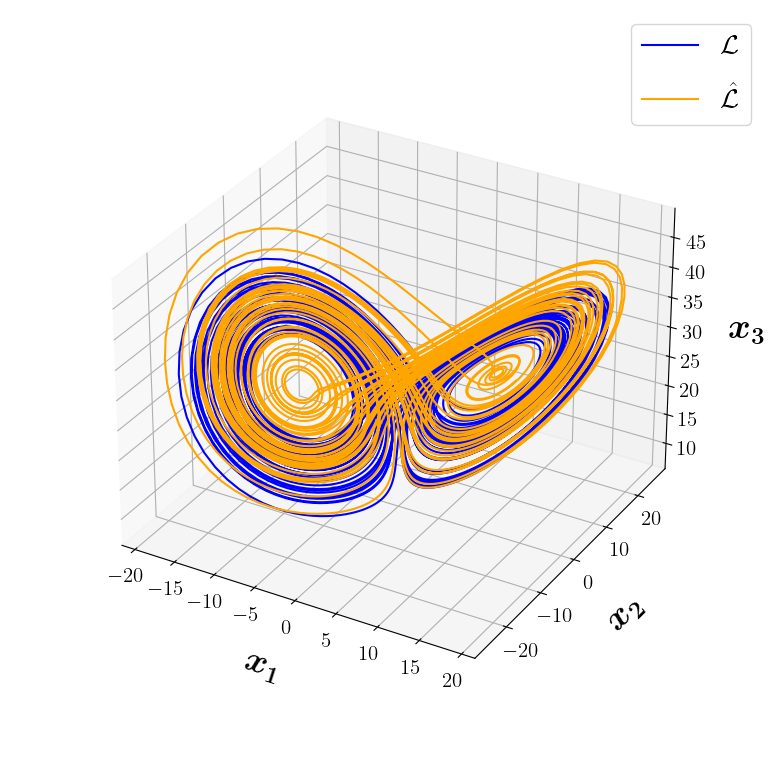

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.dist = 12
ax.zaxis.set_rotate_label(False)  # disable automatic rotation

# Plot RK4 continuation
ax.plot(states[time_ts(250):, 0], states[time_ts(250):, 1], states[time_ts(250):, 2], color='blue', label='$\mathcal{L}$')

# Plot reservoir computer continuation
ax.plot(predictions[time_ts(50):, 0], predictions[time_ts(50):, 1], predictions[time_ts(50):, 2], color='orange', label='$\mathcal{\hat{L}}$')

ax.set_xlabel(r'$\boldsymbol{x_1}$', size=25, labelpad= 20)
ax.set_ylabel(r'$\boldsymbol{x_2}$', size=25, labelpad= 20)
ax.set_zlabel(r'$\boldsymbol{x_3}$', size=25, labelpad = 20, rotation = 0)
ax.legend(fontsize=20, labelspacing=1.0, loc='best')
plt.tight_layout()

# Show the plot
plt.savefig(f'drive/My Drive/thesis_figures/chapter_3/Lorenz_attractor_reconstruction_with_RC_example.pdf',transparent = True, bbox_inches = 'tight')

# Object for RC simulation in bulk.

In [ ]:
class ReservoirComputer_BulkSimulation(ReservoirComputer):
    def __init__(self, drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma):
        super().__init__(drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma)

    def predict_100(self, t_predict):
        predictions_100 = []
        for _ in range(100):
            self.reinitialise_state()
            predictions = self.predict(t_predict)
            predictions_100.append(predictions)

        print("Predictions complete")
        return np.array(predictions_100)

    def simulate_100(self, t_listen, t_train, t_predict):

        self.listen(t_listen)
        self.train(t_train)
        trajectories = self.predict_100(t_predict)
        return np.array(trajectories)

# Evaluate time frame for training and prediction in later experiments

In [ ]:
# Initialise RC object that performs an exploartion of a state space after training
RC_B = ReservoirComputer_BulkSimulation(lorenz, reservoir_size, connectivity, spectral_radius, gamma, sigma)

In [ ]:
# initialise time periods for each stage
times = (100, 100, 100)

# set spectral radius
RC_B.set_spectral_radius(0.1)

#start timer, perform training and exploration
start_time = time.time()
trajectories = RC_B.simulate_100(*times)
#end timer and calculate how long the exploration took
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to execute 100 simulations: {elapsed_time:.4f} seconds")

Predictions complete
Time taken to execute 100 simulations: 298.7419 seconds


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to load data saved from expeiments from drive
def load_dictionary(file_path):
    with open(file_path, 'rb') as file:
        loaded_dictionary = pickle.load(file)
    print(f"Data loaded successfully from {file_path}")
    return loaded_dictionary

# Generate figure from random initialisations of M (index 23, 24) for rho = 0.6



In [ ]:
#filepath containing exploartion that was stored in drive (To be understood )
file_path = f'drive/My Drive/bifurcation_analysis_data/0.6000000000000001_M.pkl'

In [ ]:
trajectories_bulk, _ = load_dictionary(file_path)
trajectory_set_M_23 = trajectories_bulk[23]
trajectory_set_M_24 = trajectories_bulk[24]

Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.6000000000000001_M.pkl


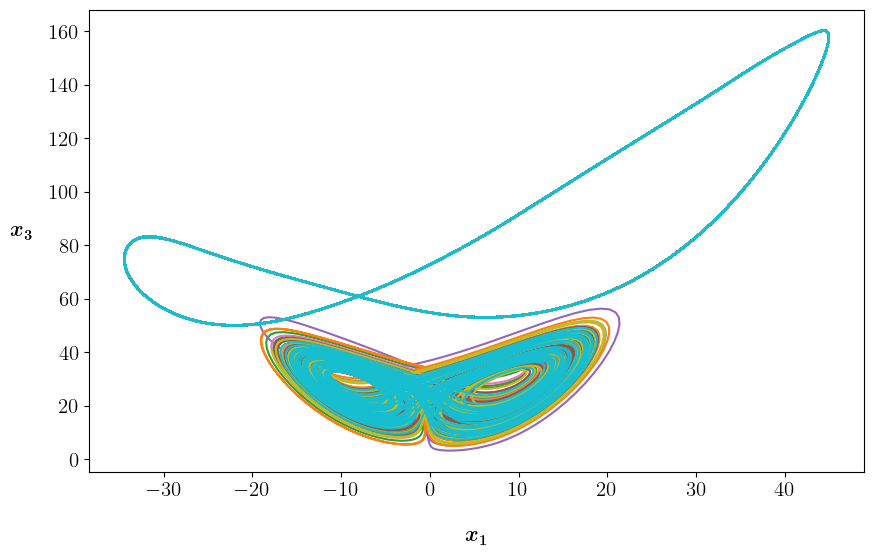

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(100):
    t = trajectory_set_M_23[i]
    x1 = t[time_ts(60):, 0]  # Extract first component
    x3 = t[time_ts(60):, 2]  # Extract first component
    plt.plot(x1, x3)

plt.xlabel(r'$\boldsymbol{x_1}$', size=15, labelpad= 20)
plt.ylabel(r'$\boldsymbol{x_3}$', size=15, labelpad= 20, rotation = 0)
plt.savefig(f'drive/My Drive/thesis_figures/chapter_4/State_space_rho_0.6_M_23_for_comparison_with_topologies.pdf',transparent = True, bbox_inches = 'tight')


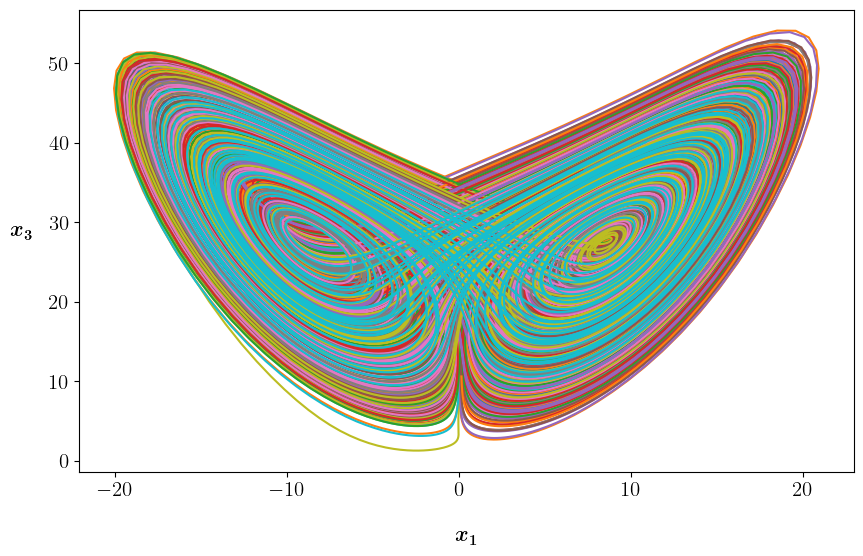

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(100):
    t = trajectory_set_M_24[i]
    x1 = t[time_ts(60):, 0]  # Extract first component
    x3 = t[time_ts(60):, 2]  # Extract first component
    plt.plot(x1, x3)

plt.xlabel(r'$\boldsymbol{x_1}$', size=15, labelpad= 20)
plt.ylabel(r'$\boldsymbol{x_3}$', size=15, labelpad= 20, rotation = 0)
plt.savefig(f'drive/My Drive/thesis_figures/chapter_4/State_space_rho_0.6_M_24_for_comparison_with_topologies.pdf',transparent = True, bbox_inches = 'tight')


# Generate comparison figures for rho = 0.1 vs 0.6

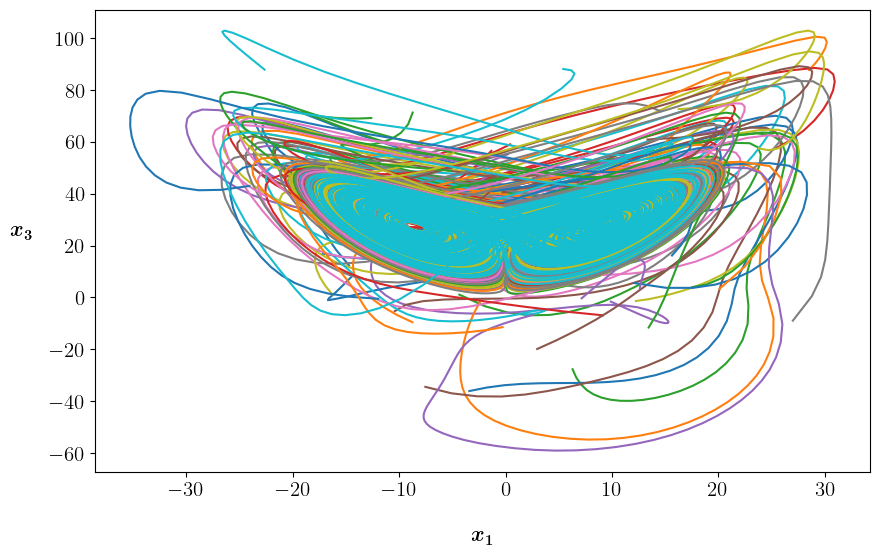

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(100):
    t = trajectories[i]
    x1 = t[:, 0]  # Extract first component
    x3 = t[:, 2]  # Extract first component
    plt.plot(x1, x3)

plt.xlabel(r'$\boldsymbol{x_1}$', size=15, labelpad= 20)
plt.ylabel(r'$\boldsymbol{x_3}$', size=15, labelpad= 20, rotation = 0)
#plt.title('Lorenz Attractor Simulation')
#plt.show()
plt.savefig(f'drive/My Drive/thesis_figures/chapter_4/100_random_ICs_for_rho_0.6_from_initialisation.pdf',transparent = True, bbox_inches = 'tight')


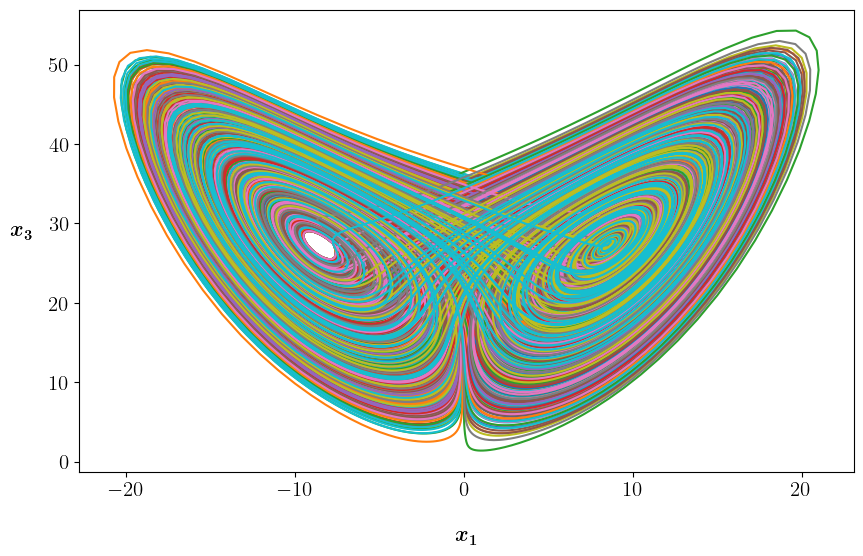

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(100):
    t = trajectories[i]
    x1 = t[time_ts(60):, 0]  # Extract first component
    x3 = t[time_ts(60):, 2]  # Extract first component
    plt.plot(x1, x3)

plt.xlabel(r'$\boldsymbol{x_1}$', size=15, labelpad= 20)
plt.ylabel(r'$\boldsymbol{x_3}$', size=15, labelpad= 20, rotation = 0)
plt.savefig(f'drive/My Drive/thesis_figures/chapter_4/100_random_ICs_for_rho_0.6_on_attractors.pdf',transparent = True, bbox_inches = 'tight')


# Generate figure of random initialisations fro rho = 0.1


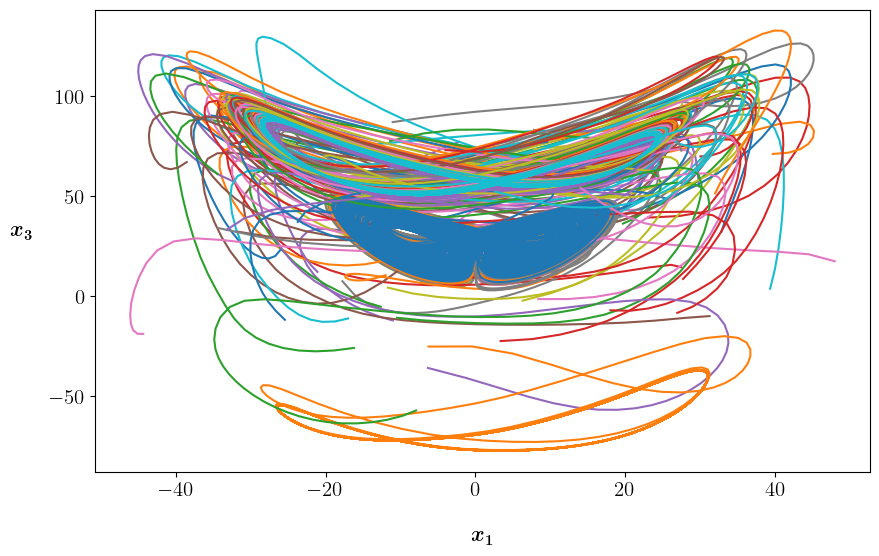

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(100):
    t = trajectories[i]
    x1 = t[:, 0]  # Extract first component
    x3 = t[:, 2]  # Extract first component
    plt.plot(x1, x3)

plt.xlabel(r'$\boldsymbol{x_1}$', size=15, labelpad= 20)
plt.ylabel(r'$\boldsymbol{x_3}$', size=15, labelpad= 20, rotation = 0)
#plt.title('Lorenz Attractor Simulation')
#plt.show()
plt.savefig(f'drive/My Drive/thesis_figures/chapter_4/100_random_ICs_for_rho_0.1_from_initialisation.pdf',transparent = True, bbox_inches = 'tight')


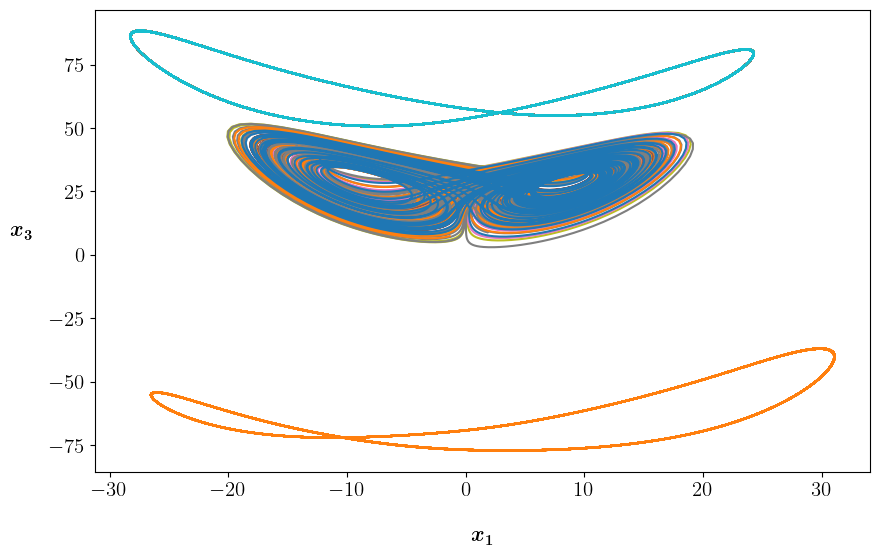

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(100):
    t = trajectories[i]
    x1 = t[time_ts(60):, 0]  # Extract first component
    x3 = t[time_ts(60):, 2]  # Extract first component
    plt.plot(x1, x3)

plt.xlabel(r'$\boldsymbol{x_1}$', size=15, labelpad= 20)
plt.ylabel(r'$\boldsymbol{x_3}$', size=15, labelpad= 20, rotation = 0)
plt.savefig(f'drive/My Drive/thesis_figures/chapter_4/100_random_ICs_for_rho_0.1_on_attractors.pdf',transparent = True, bbox_inches = 'tight')


# Single Bifurcation Analysis - $ \rho $

if repeated for randomised matrix win and m. learn if it is solely dependent on drive and spectral radius.

In [ ]:
RC_B = ReservoirComputer_BulkSimulation(lorenz, reservoir_size, connectivity, spectral_radius, gamma, sigma)

In [ ]:
spectral_radii = np.linspace(0, 0.8, 17)
spectral_radii_group_1 = spectral_radii[:8]
spectral_radii_group_2 = spectral_radii[8:]

In [ ]:
spectral_radii_group_1

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35])

In [ ]:
times = (100, 100, 100)

In [ ]:
bulky_trajectories = {}

In [ ]:
for p in spectral_radii_group_1:
  RC_B.set_spectral_radius(p)
  bulky_trajectories[p] = RC_B.simulate_100(*times)
  print(f"\033[1mSimulation complete for ρ = {p}\033[0m")

In [ ]:
for p in spectral_radii_group_2:
  RC_B.set_spectral_radius(p)
  bulky_trajectories[p] = RC_B.simulate_100(*times)
  print(f"\033[1mSimulation complete for ρ = {p}\033[0m")

# Store results of simulation to avoid recalculation

In [ ]:
drive.mount('/content/drive')
file_path = 'drive/My Drive/bifurcation_analysis_data/spectral_radius_00_simulations_1to10.npz'
np.savez_compressed(file_path, **bulky_trajectories)
print(f'Dictionary saved to {file_path}')

# Load the stored simulations results

In [ ]:
drive.mount('/content/drive')
file_path = 'drive/My Drive/bifurcation_analysis_data/spectral_radius_00_simulations_1to10.npz'
loaded_data = np.load(file_path)
bulky_trajectories_loaded = {int(key): loaded_data[key] for key in loaded_data}
print("Data loaded successfully")

# Display simulations for analysis

In [ ]:
def display_bifurcation_simulation(ax, trajectories, title):
    for i in range(100):
        t = trajectories[i]
        x1 = t[60:, 0]
        x3 = t[60:, 2]
        ax.plot(x1, x3)
    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x3')

In [ ]:
num_plots = len(bulky_trajectories)
num_cols = 2
num_rows = int(np.ceil(num_plots / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows), constrained_layout=True)
axs = axs.flatten()

for ax, (p, trajectories) in zip(axs, bulky_trajectories.items()):
    if p != 0:
      display_bifurcation_simulation(ax, trajectories, f'Spectral Radius : {p}')

plt.show()

# Code that takes in array of trajectories and then returns a vector of classifications of attractors present.

<ol start="0">
    <li>Other Attractor</li>
    <li>Lorenz Attractor</li>
    <li>Limit Cycle</li>
    <li>Fixed Point</li>
</ol>


In [ ]:
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from scipy.spatial.distance import cdist

def is_fixed_point(traj):
    return np.allclose(traj[:-1], traj[1:], atol=1e-3)

def is_limit_cycle(traj):
    if len(traj) < 2:
        return False

    distances = cdist(traj, traj)

    for period in range(2, len(traj) // 2):
        if np.all(distances[0, 0::period] < 1):
            return True

    return False

def is_lorenz_attractor(traj):
    x, y, z = traj[:, 0], traj[:, 1], traj[:, 2]
    total_points = len(traj)
    points_within_bounds = (
        np.sum((x >= -20) & (x <= 20)) +
        np.sum((y >= -30) & (y <= 30)) +
        np.sum((z >= -5) & (z <= 55))
    )
    percentage_within_bounds = points_within_bounds / (3 * total_points)
    if percentage_within_bounds >= 0.95:
        return True
    return False

def classify_single_trajectory(traj):
    if is_fixed_point(traj):
        return 0
    elif is_limit_cycle(traj):
        return 1
    elif is_lorenz_attractor(traj):
        return 2
    else:
        return 3

In [ ]:
def classify_attractor(trajectories):
    classifications = [classify_single_trajectory(traj) for traj in trajectories]
    return classifications

In [ ]:
RC_B = ReservoirComputer_BulkSimulation(lorenz, reservoir_size, connectivity, spectral_radius, gamma, sigma)

In [ ]:
times = (100, 100, 100)
RC_B.set_spectral_radius(0.1)
trajectories = RC_B.simulate_100(*times)

KeyboardInterrupt: 

In [ ]:
classifications = classify_attractor(trajectories[:, time_ts(60):])
classes = ["Fixed Point", "Limit Cycle", "Lorenz Attractor", "Other Attractor"]

num_trajectories = len(trajectories)
num_cols = 4
num_rows = (num_trajectories + num_cols - 1) // num_cols

fig = plt.figure(figsize=(15, 5 * num_rows))

for i, (traj, cls) in enumerate(zip(trajectories, classifications)):
    row = i // num_cols
    col = i % num_cols

    ax = fig.add_subplot(num_rows, num_cols, i+1, projection='3d')
    ax.plot(traj[time_ts(60):, 0], traj[time_ts(60):, 1], traj[time_ts(60):, 2], label=f"Simulation {i} contains {classes[cls]}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

plt.tight_layout()
plt.show()

# Frequency Domain analysis of Attractors

In [ ]:
class DynamicalSystem:

    def __init__(self):
        self.state = np.array([0, 0, 0])

    def __call__(self, t, u):
        x_dot = u[1] + 2 * u[0] * u[1] + u[0] * u[2]
        y_dot = 1 - 2 * u[0]**2 + u[1] * u[2]
        z_dot = u[0] - u[0]**2 - u[1]**2
        return np.array([x_dot, y_dot, z_dot])

    def reinitialize_ic(self):
        self.state = np.array([0, 0, 0])

    def randomize_ic(self):
        self.state = 2 * (np.random.rand(self.state.size) - 0.5)

In [ ]:
ds = DynamicalSystem()
ds.randomize_ic()
dt = 0.01
t_end = 300
num_timesteps = int(t_end / dt)

states = [ds.state]
t = 0.0
for _ in range(num_timesteps):
    ds.state = RK4step(ds, ds.state, t, dt)
    states.append(ds.state)
    t += dt

states = np.array(states)

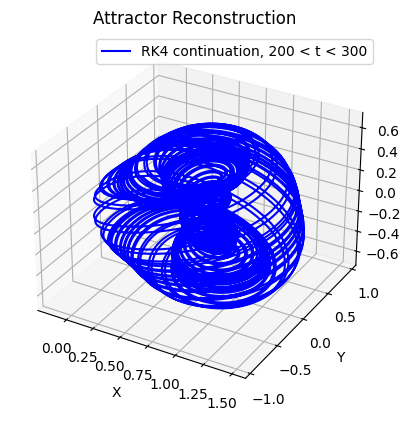

In [ ]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot RK4 continuation
ax.plot(states[200:, 0], states[200:, 1], states[200:, 2], color='blue', label='RK4 continuation, 200 < t < 300')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Attractor Reconstruction')

ax.legend()

# Show the plot
plt.show()

In [ ]:
def fft_analysis(trajectory, timestep):
    shape = trajectory.shape[0]
    n = trajectory.size
    sampling_rate = 1 / timestep
    freq = np.fft.fftfreq(shape, d=1/sampling_rate).reshape(shape)
    fft_vals = np.fft.fftn(trajectory)
    fft_real = np.real(fft_vals)

    for i in range(fft_real.shape[1]):
        plt.figure()
        plt.plot(freq, fft_vals[:, i])
        plt.xlabel('Frequency')
        plt.ylabel('FFT Magnitude')
        plt.title(f'trajectory component [{i+1}]')
        plt.show()

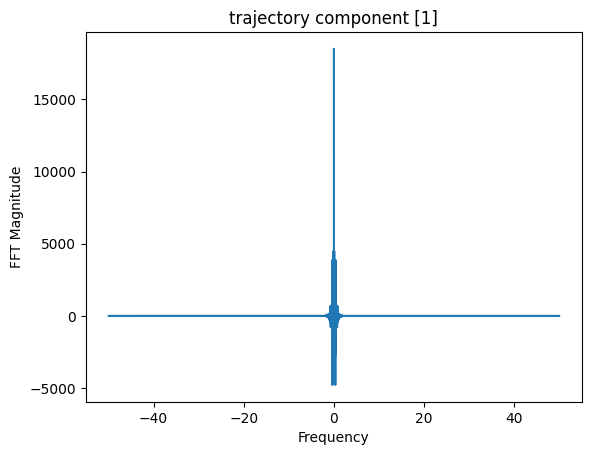

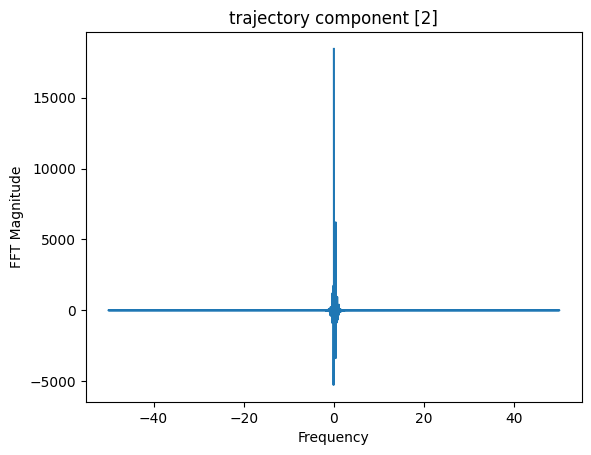

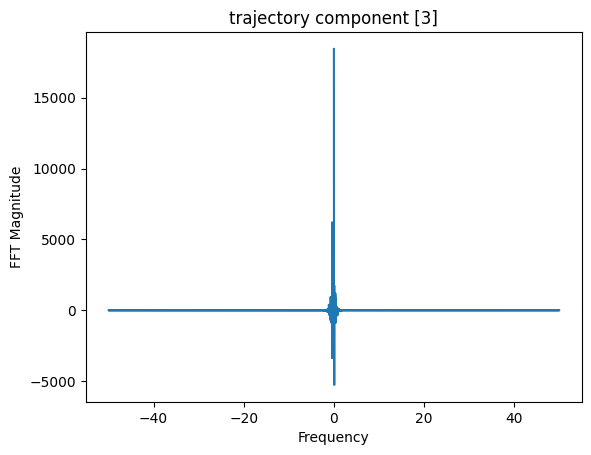

In [ ]:
fft_analysis_ds = fft_analysis(states, dt)